In [1]:
import pandas as pd
import scipy
import numpy as np
from sklearn.metrics import mean_absolute_error
from datetime import datetime
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import time
from sklearn.metrics import mean_squared_error
import math

Firstly, we import the entire ratings and movies data set from the csv files downloaded via the movie lens website as mentioned in the instruction. The ratings dataset consists of userids, movieids, ratings and timestamp and the movies dataset consists of movieids, titles and the genres. Since the timestamp in the dataset is the no of seconds since the inception of this dataset, we convert it into year so that it becomes easy to subset it further for our analysis and/or model building exercise. 

In [4]:
#Sampling the data

data=pd.read_csv("../../data/ml-20m/ratings.csv")

genre_data=pd.read_csv("../../data/ml-20m/movies.csv")

movie_data_ratings_data=data.merge(genre_data,on = 'movieId',how = 'inner')

movie_data_ratings_data['timestamp'] =pd.to_datetime(movie_data_ratings_data['timestamp'],unit='s')
movie_data_ratings_data['timestamp'] =movie_data_ratings_data['timestamp'].dt.year

We have done some elementary EDA on the movielens dataset to get a gist of the average ratings, popular movies, no of users etc.

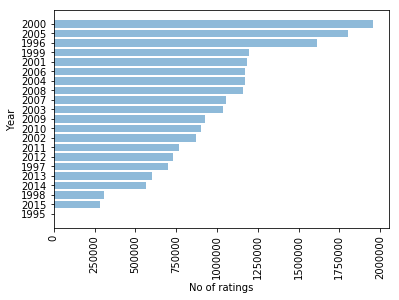

In [5]:
data_1=movie_data_ratings_data.groupby('timestamp')['rating'].count().reset_index().sort_values('rating')
objects = data_1['timestamp']
y_pos = np.arange(len(objects))
performance = list(data_1['rating'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('No of ratings')
plt.ylabel('Year')
plt.xticks(rotation=90)
plt.savefig('../../output/No_rating_vs_Year'+'.png')

As we can see from the Histogram above, the year 2000 had the most no of ratings while 2015 has the fewest number of ratings. It could be possible that the entire 2015 is not captured.
Since we can see that 2015 has the least number of ratings, we started with it for our model building purpose

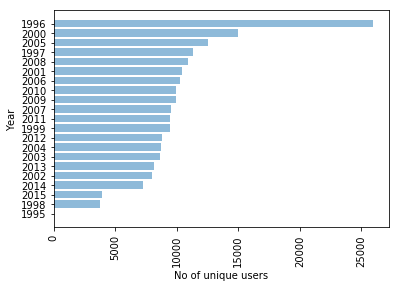

In [6]:
data_2=movie_data_ratings_data.groupby('timestamp')['userId'].nunique().reset_index().sort_values('userId')
objects = data_2['timestamp']
y_pos = np.arange(len(objects))
performance = list(data_2['userId'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('No of unique users')
plt.ylabel('Year')
plt.xticks(rotation=90)
plt.savefig('../../output/No_Users_vs_Year'+'.png')

The plot above shows the number of unique users against the year. Clearly, 1996 had the most number of users and 1995/2015 had fewest number of users, i.e. around 4000

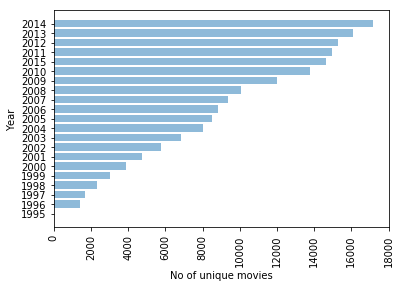

In [7]:
data_3=movie_data_ratings_data.groupby('timestamp')['movieId'].nunique().reset_index().sort_values('movieId')
objects = data_3['timestamp']
y_pos = np.arange(len(objects))
performance = list(data_3['movieId'])

plt.barh(y_pos, performance, align='center', alpha=0.5)
plt.yticks(y_pos, objects)
plt.xlabel('No of unique movies')
plt.ylabel('Year')
plt.xticks(rotation=90)
plt.savefig('../../output/No_Movies_vs_Year'+'.png')

The above plot shows the number of unique movies against the year. We can see a trend here in the sense that there were fvery few movies in the mid and late 90's where as 2000 onwards, the number of movies released increased. For eg, 2014 shows 8x increase in the number of movies released

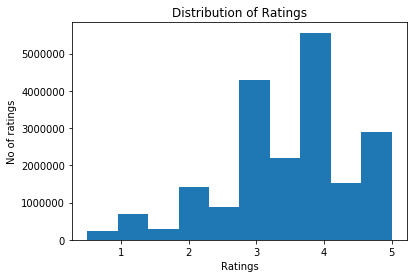

In [8]:
plt.hist(movie_data_ratings_data['rating'])
plt.ylabel('No of ratings')
plt.xlabel('Ratings')
plt.title('Distribution of Ratings')
plt.savefig('../../output/Ratings Distribution'+'.png')

The Histogram above showes the distrbudion of ratings in the entire dataset. This seems somewhat a negatively skewed distribution. We can clearly see that the mean rating and median is above 3. To get a better view of the distribution of the ratings, we can look at the ratings by deciles

In [9]:
decile=pd.DataFrame(movie_data_ratings_data['rating'].quantile(list(np.arange(0.1,1.1,0.1)))).reset_index().rename(columns={'index':'decile'})
decile

,decile,rating
0,0.1,2.0
1,0.2,3.0
2,0.3,3.0
3,0.4,3.5
4,0.5,3.5
5,0.6,4.0
6,0.7,4.0
7,0.8,4.5
8,0.9,5.0
9,1.0,5.0


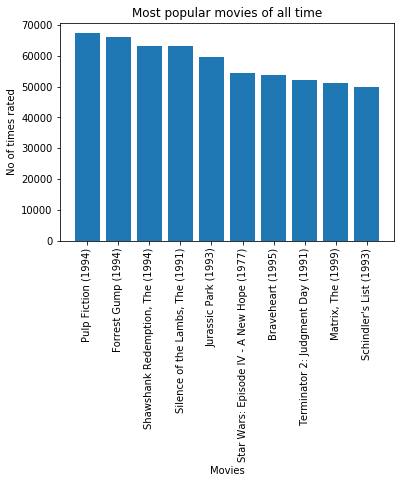

In [10]:
data_4=movie_data_ratings_data.groupby('title')['movieId'].count().reset_index().sort_values('movieId',ascending=False)
objects = data_4['title'][:10]
y_pos = np.arange(len(objects))
performance = list(data_4['movieId'][:10])
plt.bar(np.arange(len(objects)),data_4['movieId'][:10])
plt.xlabel('Movies')
plt.ylabel('No of times rated')
plt.title('Most popular movies of all time')
plt.xticks(y_pos,objects,rotation=90)
plt.savefig('../../output/Popular_movies_all_time'+'.png')

The above graph shows the top 10 popular movies of all time. This is consistent with the imdb ratings of top 10 movies 